<a href="https://colab.research.google.com/github/SaraWestWA/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/SW_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Import data and arrange in inital dataframe

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train1 = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test1 = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train1.shape, test1.shape

((59400, 41), (14358, 40))

## Profile data

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train1, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Split and get baselines
 Do train/validate/test split with the Tanzania Waterpumps data.
 
 Begin with baselines for classification.
### Run after point

In [42]:
# copy dataframes to make restarting easier

train = train1.copy()
test = test1.copy()

In [43]:
# Train / Validate Split
train, val = train_test_split(train, test_size=0.24, random_state=42)

train.shape, val.shape

((45144, 41), (14256, 41))

In [44]:
# Get baselines
train['status_group'].value_counts(normalize=True)

functional                 0.542331
non functional             0.384702
functional needs repair    0.072967
Name: status_group, dtype: float64

## Wrangle Data & Examine Features
 Select features.

In [45]:
train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [46]:
# Look at longitude and latitude for known issues
train[['longitude', 'latitude']].describe()

,longitude,latitude
count,45144.000000,4.514400e+04
mean,34.092420,-5.707650e+00
std,6.544197,2.943521e+00
min,0.000000,-1.164944e+01
25%,33.085290,-8.532856e+00
50%,34.914161,-5.021724e+00
75%,37.180585,-3.327147e+00
max,40.345193,-2.000000e-08


In [48]:
# Columns to keep 'as is' or wrangle in this iteration (15):
keep_now = [
            'longitude',
            'latitude',
            'basin',
            'region',
            'district_code',
            'extraction_type', # compare
            'management',
            'management_group',
            'payment_type',
            'water_quality', # compare
            'quantity',
            'source', # compare
            'source_class',
            'waterpoint_type', # compare
            'status_group']

#  Columns requiring cleaning: (4)
to_clean = [
            'date_recorded', # make year only
            'installer', # make boolean 29% DWE
            'population', # 26% zero, bin or drop
            'scheme_management']# replace zeros with'unknown'

# Columns to be imputed (2):
to_impute_num = [
            'gps_height', # many zeros, impute
            'construction_year'] # 35% missing, impute

# Columns to be imputed (2):
to_impute_bool = [
            'public_meeting', # boolean with missing values
            'permit'] # boolean with missing values

# Columns to compare to others kept(6):
to_compare = [ 
           'region_code', # %s very similar to region names for top 10 values
            'extraction_type_group',  # compare to extraction
            'extraction_type_class',  # compare to extraction
            'quality_group',  # compare to water_quality
            'source_type',  # compare similar to source
            'waterpoint_type_group'] # very similar to waterpoint_type]

# Columns to drop permanently (6):
goodbye = [
           'id', #unneeded
            'amount_tsh', # 70% zeros
            'num_private', #98%+ zero
            'recorded_by', # extraneaous all one value
            'payment', # duplicate of payment_type
            'quantity_group'] # duplicate of quantity

#  High cardinality(6):
hi_cardinality = [
          'funder', # very high cardinality
          'wpt_name', # very high cardinality
          'subvillage', # very high cardinality
          'ward', # very high cardinality
          'lga', # high cardinality
          'scheme_name'] # very high cardinality

# high cardinality could be taken out in pipeline with this code:
# # Get a list of all categorical features with cardinality <= 100
# categorical_features = cardinality[cardinality <= 100].index.tolist()

In [49]:
import numpy as np

# Create function to wrangle all three data sets

def wrangle(X):
  #  copying is good to avoid warnings
  X = X.copy()

  # # fix "zero" latitude
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # replace zeros in longitude and latitude with Nan
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)

  # Drop extraneous columns
  X = X.drop(columns = goodbye)

  # Drop columns to be cleaned
  X = X.drop(columns = to_clean)
  
  # Drop columns to be boolean imputed
  X = X.drop(columns = to_impute_bool)

  # Drop columns to be compared
  X = X.drop(columns = to_compare)

  # Drop columns with high cardinality
  X = X.drop(columns = hi_cardinality)

  # Return wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


## Target Vector / Features Matrix Split

In [50]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with remaining train columns except the target
features = list(train.drop(columns = [target]))
features

['gps_height',
 'longitude',
 'latitude',
 'basin',
 'region',
 'district_code',
 'construction_year',
 'extraction_type',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type']

In [51]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Create pipeline
Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [52]:
# # #### To copy only
# import category_encoders as ce
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     SimpleImputer(strategy='mean'), 
#     StandardScaler(), 
#     LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
# )

# # Fit on train
# pipeline.fit(X_train, y_train)

# # Score on validation
# print ('Validation Accruacy', pipeline.score(X_val, y_val))

# # Predict on test
# y_pred = pipeline.predict(X_test)


In [53]:
# Imports for pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [54]:
# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

In [55]:
# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print('Validation Accuracy', pipeline.score(X_val, y_val))

# note, this was a bit higher when leaving in non-imputed boolean columns
# do they need to be imputed, or does a dropna happen automatically?

Validation Accuracy 0.7309203142536476


###Get and plot coefficients, direct code copy

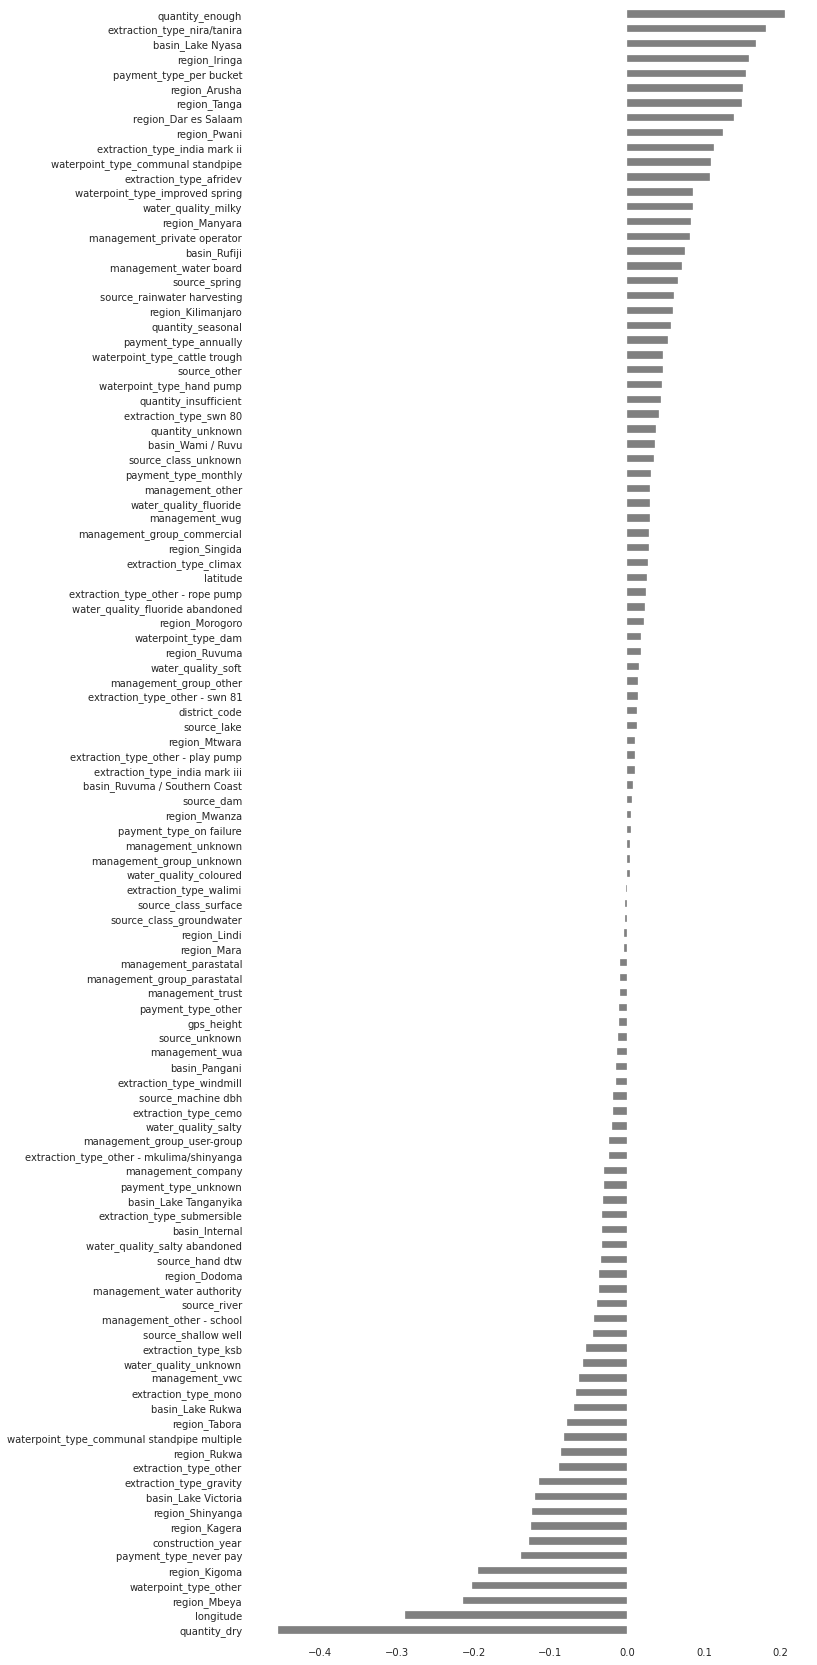

In [57]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## Decision Tree
Fit a decision tree classifier.

Get your validation accuracy score.

## Plot features importance
Get and plot your feature importances.

##Prepare Kaggle Submission
Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)



## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```
